In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append('..')

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from src.dataset import get_train_dataloader, create_transforms, apply_transforms, apply_inverse_transforms, Identity, HorizontalFlip, Rotate
from src.metrics import compute_IoU_batch, compute_pixel_accuracy_batch

# Metrics

### IoU

In [2]:
mask_all_ones = torch.ones((1,1,1000,1000))
mask_all_zeros = torch.zeros((1,1,1000,1000))
mask_random = torch.rand((1,1,1000,1000))
mask_random2 = torch.rand((1,1,1000,1000))
mask_random[mask_random > 0.5] = 1.0
mask_random[mask_random <= 0.5] = 0.0
mask_random2[mask_random2 > 0.5] = 1.0
mask_random2[mask_random2 <= 0.5] = 0.0

In [3]:
iou_random_and_ones = compute_IoU_batch(mask_random, mask_all_ones)
iou_random_and_zeros = compute_IoU_batch(mask_random, mask_all_zeros)
iou_random_and_random = compute_IoU_batch(mask_random, mask_random2)

In [4]:
assert 0.49 < iou_random_and_ones < 0.51, 'Wrong IoU for 1s and random'
assert iou_random_and_zeros == 0, 'Wrong IoU for 0s and random'
assert 0.33 < iou_random_and_random < 0.34, 'Wrong IoU for random and random'

### pixel accuracy

In [5]:
acc_random_and_ones = compute_pixel_accuracy_batch(mask_random, mask_all_ones)
acc_random_and_zeros = compute_pixel_accuracy_batch(mask_random, mask_all_zeros)
acc_random_and_random = compute_pixel_accuracy_batch(mask_random, mask_random2)

In [6]:
acc_random_and_random


tensor(0.4999)

In [7]:
assert 0.49 < acc_random_and_ones < 0.51, 'Wrong acc for 1s and random'
assert 0.49 < acc_random_and_zeros < 0.51, 'Wrong acc for 0s and random'
assert 0.49 < acc_random_and_random < 0.51, 'Wrong acc for random and random'

# Augmentations

In [8]:
train_images = np.load(os.path.join('../data/', 'gsn_img_uint8.npy'))

### Horizontal flip

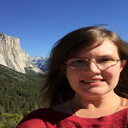

In [9]:
Image.fromarray(train_images[0])

torch.Size([2000, 3, 128, 128])


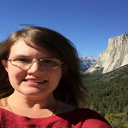

In [10]:
train_images = np.load(os.path.join('../data', 'gsn_img_uint8.npy'))
train_images_r = np.einsum('bhwc->bchw', train_images)
train_images_t_r = torch.from_numpy(train_images_r)
image_fliped_t_r= torch.flip(train_images_t_r, dims=(3,))
print(image_fliped_t_r.shape)
image_fliped_np_r = image_fliped_t_r.numpy()
image_fliped_np = np.einsum('bchw->bhwc', image_fliped_np_r)

Image.fromarray(image_fliped_np[0])

### rotation

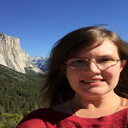

In [11]:
Image.fromarray(train_images[0])

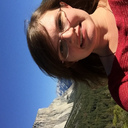

In [12]:
train_images = np.load(os.path.join('../data', 'gsn_img_uint8.npy'))
train_images_r = np.einsum('bhwc->bchw', train_images)
train_images_t_r = torch.from_numpy(train_images_r)
image_fliped_t_r = torch.rot90(train_images_t_r, k=1, dims=(2,3))
image_fliped_np_r = image_fliped_t_r.numpy()
image_fliped_np = np.einsum('bchw->bhwc', image_fliped_np_r)
Image.fromarray(image_fliped_np[0])

### self augmentation

In [13]:
images, masks = torch.rand((1, 3, 100, 100)), torch.zeros((1, 1, 100, 100))
masks[:, :, :50, :50] = 1.0

#### identity

In [14]:
transforms = create_transforms(['identity'])
image = images[0]
mask = masks[0]

In [15]:
img_transformed = apply_transforms(image, transforms=transforms)
mask_transformed = apply_transforms(mask, transforms=transforms)

In [16]:
assert image.shape == img_transformed.shape[1:], 'Shape mismatch after applying transform'
assert torch.all(image == img_transformed), 'Identity transform should not change images'
assert torch.all(mask == mask_transformed), 'Identity transform should not change masks'

In [17]:
images_inverse_transformed = apply_inverse_transforms(img_transformed, transforms=transforms)
masks_inverse_transformed = apply_inverse_transforms(mask_transformed, transforms=transforms)

In [18]:
assert images_inverse_transformed.shape == img_transformed.shape, 'Shape mismatch after applying transform'
assert torch.all(images_inverse_transformed == img_transformed), 'Inverse Identity transform should not change images'
assert torch.all(masks_inverse_transformed == mask_transformed), 'Inverse Identity transform should not change masks'

In [19]:
assert torch.all(image == images_inverse_transformed), "f'(f(x)) == x"
assert torch.all(mask == masks_inverse_transformed), "f'(f(x)) == x"

#### flip

In [35]:
transforms = create_transforms(['flip'])

In [36]:
img_transformed = apply_transforms(image, transforms=transforms)
mask_transformed = apply_transforms(mask, transforms=transforms)

In [44]:
assert image.shape == img_transformed[0].shape, 'Shape mismatch after applying transform'
assert torch.all(image != img_transformed), 'Horizontal Flip transform should change images'
assert torch.any(mask != mask_transformed), 'Horizontal Flip transform should change masks'
assert torch.all(mask[0, :50, :50] == mask_transformed[0,0,:50,50:]), 'Horizontal Flip changes pixels from left to right'
assert torch.all(mask[0, :50, :50] != mask_transformed[0,0,50:,:50]), 'Horizontal Flip changes pixels from left to right'


In [45]:
images_inverse_transformed = apply_inverse_transforms(img_transformed, transforms=transforms)
masks_inverse_transformed = apply_inverse_transforms(mask_transformed, transforms=transforms)

In [46]:
assert images_inverse_transformed.shape == img_transformed.shape, 'Shape mismatch after applying transform'
assert torch.all(images_inverse_transformed != img_transformed), 'Inverse flip transform should not change images'
assert torch.any(masks_inverse_transformed != mask_transformed), 'Inverse flip transform should not change masks'

In [47]:
assert torch.all(image == images_inverse_transformed), "f'(f(x)) == x"
assert torch.all(mask == masks_inverse_transformed), "f'(f(x)) == x"

#### rot90

In [48]:
transforms = create_transforms(['rot90'])

In [49]:
img_transformed = apply_transforms(image, transforms=transforms)
mask_transformed = apply_transforms(mask, transforms=transforms)

In [50]:
images_inverse_transformed = apply_inverse_transforms(img_transformed, transforms=transforms)
masks_inverse_transformed = apply_inverse_transforms(mask_transformed, transforms=transforms)

In [52]:
assert image.shape == img_transformed[0].shape, 'Shape mismatch after applying transform'
assert torch.all(images != img_transformed), 'Rotate transform should change images'
assert torch.any(mask != mask_transformed), 'Rotate transform should change masks'
assert torch.all(mask[0, :50, :50] == mask_transformed[0,0,50:,:50]), 'Rotate changes pixels 90 degrees'
assert torch.all(mask[0, :50, :50] != mask_transformed[0,0,:50,:50]), 'Rotate changes pixels 90 degrees'

assert images_inverse_transformed.shape == img_transformed.shape, 'Shape mismatch after applying transform'
assert torch.all(images_inverse_transformed != img_transformed), 'Inverse Rotate transform should not change images'
assert torch.any(masks_inverse_transformed != mask_transformed), 'Inverse Rotate transform should not change masks'

In [53]:
assert torch.all(image == images_inverse_transformed), "f'(f(x)) == x"
assert torch.all(mask == masks_inverse_transformed), "f'(f(x)) == x"

#### identity + flip + rot270

In [54]:
transforms = create_transforms(['identity', 'flip', 'rot90'])

In [55]:
img_transformed = apply_transforms(image, transforms=transforms)
mask_transformed = apply_transforms(mask, transforms=transforms)

In [57]:
assert image.shape == img_transformed[0].shape, 'Shape mismatch after applying transform'
assert img_transformed.shape[0] == 3, 'Transformed shape is 3'

assert torch.all(image == img_transformed[0]), 'Identity transform should not change images'
assert torch.all(mask == mask_transformed[0]), 'Identity transform should not change masks'

assert torch.any(image != img_transformed[1]), 'Horizontal Flip transform should change images'
assert torch.any(mask != mask_transformed[1]), 'Horizontal Flip transform should change masks'

assert torch.any(image != img_transformed[2]), 'Rotate transform should change images'
assert torch.any(mask != mask_transformed[2]), 'Rotate transform should change masks'


assert torch.all(mask[0, :50, :50] == mask_transformed[1,0,:50,50:]), 'Horizontal Flip changes pixels from left to right'
assert torch.all(mask[0, :50, :50] != mask_transformed[1,0,50:,:50]), 'Horizontal Flip changes pixels from left to right'

assert torch.all(mask[0, :50, :50] == mask_transformed[2,0,50:,:50]), 'Rotate changes pixels 90 degrees'
assert torch.all(mask[0, :50, :50] != mask_transformed[2,0,:50,:50]), 'Rotate changes pixels 90 degrees'

In [58]:
images_inverse_transformed = apply_inverse_transforms(img_transformed, transforms=transforms)
masks_inverse_transformed = apply_inverse_transforms(mask_transformed, transforms=transforms)

In [59]:
assert images_inverse_transformed.shape == img_transformed.shape, 'Shape mismatch after applying inverse transform'

assert torch.all(masks_inverse_transformed[0] == mask), 'Inverse transforms should not change masks'
assert torch.all(masks_inverse_transformed[1] == mask), 'Inverse transforms should not change masks'
assert torch.all(masks_inverse_transformed[2] == mask), 'Inverse transforms should not change masks'

assert torch.all(images_inverse_transformed[0] == image), 'Inverse transforms should not change image'
assert torch.all(images_inverse_transformed[1] == image), 'Inverse transforms should not change image'
assert torch.all(images_inverse_transformed[2] == image), 'Inverse transforms should not change image'